In [1]:
# default_exp core

# bengaliai-cv19

> API details.

In [1]:
#hide
from nbdev.showdoc import *
import time
from fastai.vision import *
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import gc

import cv2

In [2]:
# export

#https://www.kaggle.com/maxlenormand/cropping-to-character-resizing-images
def crop_resize_scaled(df, resize_size = 128):
    HEIGHT = 137
    WIDTH = 236
    CROP_SIZE = resize_size
    original_img_size = HEIGHT * WIDTH
    cropped_img_size = CROP_SIZE * CROP_SIZE
    
    print(f"Original shape of images: {original_img_size}\nCropped & resized shape of images: {cropped_img_size}")
    print(f"Reduction fatio: {np.round(original_img_size/cropped_img_size, 3)}")
    print(df.shape)
    resized_df = df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH)
    
    cropped_imgs = {}
    for img_id in tqdm(range(df.shape[0])):
        img = resized_df[img_id]
        _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        
        idx = 0 
        ls_xmin = []
        ls_ymin = []
        ls_xmax = []
        ls_ymax = []
        for cnt in contours:
            idx += 1
            x,y,w,h = cv2.boundingRect(cnt)
            ls_xmin.append(x)
            ls_ymin.append(y)
            ls_xmax.append(x + w)
            ls_ymax.append(y + h)
        xmin = min(ls_xmin)
        ymin = min(ls_ymin)
        xmax = max(ls_xmax)
        ymax = max(ls_ymax)

        roi = img[ymin:ymax,xmin:xmax]
        resized_roi = cv2.resize(roi, (resize_size, resize_size))
        cropped_imgs[df.image_id[img_id]] = resized_roi.reshape(-1)
        
    resized = pd.DataFrame(cropped_imgs).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized #out_df

In [5]:
# export

# https://www.kaggle.com/iafoss/image-preprocessing-128x128
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize_img(img0, size=128, pad=16):
    HEIGHT = 137
    WIDTH = 236
    SIZE = size
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


# https://www.kaggle.com/maxlenormand/cropping-to-character-resizing-images
def crop_resize(df, resize_size = 128):
    HEIGHT = 137
    WIDTH = 236
    SIZE = resize_size
    
    resized_df = 255-df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
    cropped_imgs = {}
    for img_id in tqdm(range(df.shape[0])):
        img = resized_df[img_id]
        
        resized_roi = crop_resize_img(img)
        cropped_imgs[df.image_id[img_id]] = resized_roi.reshape(-1)
        
    resized = pd.DataFrame(cropped_imgs).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized #out_df
    
    
def resize_only(df, resize_size = 128):
    HEIGHT = 137
    WIDTH = 236
    SIZE = resize_size
    
    resized_df = 255-df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
    cropped_imgs = {}
    for img_id in tqdm(range(df.shape[0])):
        img = resized_df[img_id]
        
        resized_roi = cv2.resize(img, (168,96))
        cropped_imgs[df.image_id[img_id]] = resized_roi.reshape(-1)
        
    resized = pd.DataFrame(cropped_imgs).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized #out_df

In [6]:
# export

def imagePreprocessing(crop_func, file_in, file_out):
    df = pd.read_parquet(file_in)
    df.reset_index(inplace=True,drop = True)#
    print(df.shape)
    cropped_df = crop_func(df, resize_size = 128)
    cropped_df.to_feather(file_out)
    del cropped_df
    gc.collect()
    

In [8]:
%%time
source = Path('/home/kaggle/bengaliai-cv19/input')

for i in range(4):
    file_in = source/('test_image_data_' + str(i)+'.parquet')
    file_out = source/('test_image_data_crop_scaled_' + str(i)+'.feather')
    print(file_in, file_out)
    imagePreprocessing(crop_resize_scaled,file_in, file_out)
    print(str(i) + ' Done')

/home/kaggle/bengaliai-cv19/input/test_image_data_0.parquet /home/kaggle/bengaliai-cv19/input/test_image_data_crop_scaled_0.feather


100%|██████████| 3/3 [00:00<00:00, 140.84it/s]

(3, 32333)
Original shape of images: 32332
Cropped & resized shape of images: 16384
Reduction fatio: 1.973
(3, 32333)


0 Done
/home/kaggle/bengaliai-cv19/input/test_image_data_1.parquet /home/kaggle/bengaliai-cv19/input/test_image_data_crop_scaled_1.feather


100%|██████████| 3/3 [00:00<00:00, 368.64it/s]

(3, 32333)
Original shape of images: 32332
Cropped & resized shape of images: 16384
Reduction fatio: 1.973
(3, 32333)


1 Done
/home/kaggle/bengaliai-cv19/input/test_image_data_2.parquet /home/kaggle/bengaliai-cv19/input/test_image_data_crop_scaled_2.feather


100%|██████████| 3/3 [00:00<00:00, 267.40it/s]

(3, 32333)
Original shape of images: 32332
Cropped & resized shape of images: 16384
Reduction fatio: 1.973
(3, 32333)


2 Done
/home/kaggle/bengaliai-cv19/input/test_image_data_3.parquet /home/kaggle/bengaliai-cv19/input/test_image_data_crop_scaled_3.feather


100%|██████████| 3/3 [00:00<00:00, 367.02it/s]

(3, 32333)
Original shape of images: 32332
Cropped & resized shape of images: 16384
Reduction fatio: 1.973
(3, 32333)


3 Done
CPU times: user 8min 38s, sys: 3.18 s, total: 8min 41s
Wall time: 2min 18s


In [8]:
%%time
source = Path('/home/kaggle/bengaliai-cv19/input')

for i in range(4):
    file_in = source/('train_image_data_' + str(i)+'.parquet')
    file_out = source/('train_image_data_crop_' + str(i)+'.feather')
    print(file_in, file_out)
    imagePreprocessing(crop_resize,file_in, file_out)
    print(str(i) + ' Done')
    

/home/kaggle/bengaliai-cv19/input/train_image_data_0.parquet /home/kaggle/bengaliai-cv19/input/train_image_data_crop_0.feather
(50210, 32333)


100%|██████████| 50210/50210 [00:17<00:00, 2876.40it/s]


0 Done
/home/kaggle/bengaliai-cv19/input/train_image_data_1.parquet /home/kaggle/bengaliai-cv19/input/train_image_data_crop_1.feather
(50210, 32333)


100%|██████████| 50210/50210 [00:16<00:00, 3031.24it/s]


1 Done
/home/kaggle/bengaliai-cv19/input/train_image_data_2.parquet /home/kaggle/bengaliai-cv19/input/train_image_data_crop_2.feather
(50210, 32333)


100%|██████████| 50210/50210 [00:18<00:00, 2669.35it/s]


2 Done
/home/kaggle/bengaliai-cv19/input/train_image_data_3.parquet /home/kaggle/bengaliai-cv19/input/train_image_data_crop_3.feather
(50210, 32333)


100%|██████████| 50210/50210 [00:18<00:00, 2643.64it/s]


3 Done
CPU times: user 13min 36s, sys: 21.1 s, total: 13min 57s
Wall time: 6min 52s


In [7]:
%%time
source = Path('/home/kaggle/bengaliai-cv19/input')

for i in range(4):
    file_in = source/('train_image_data_' + str(i)+'.parquet')
    file_out = source/('train_image_data_resize_only_' + str(i)+'.feather')
    print(file_in, file_out)
    imagePreprocessing(resize_only,file_in, file_out)
    print(str(i) + ' Done')

/home/kaggle/bengaliai-cv19/input/train_image_data_0.parquet /home/kaggle/bengaliai-cv19/input/train_image_data_resize_only_0.feather
(50210, 32333)


100%|██████████| 50210/50210 [00:08<00:00, 6051.21it/s]


0 Done
/home/kaggle/bengaliai-cv19/input/train_image_data_1.parquet /home/kaggle/bengaliai-cv19/input/train_image_data_resize_only_1.feather
(50210, 32333)


100%|██████████| 50210/50210 [00:08<00:00, 5899.09it/s]


1 Done
/home/kaggle/bengaliai-cv19/input/train_image_data_2.parquet /home/kaggle/bengaliai-cv19/input/train_image_data_resize_only_2.feather
(50210, 32333)


100%|██████████| 50210/50210 [00:08<00:00, 5738.29it/s]


2 Done
/home/kaggle/bengaliai-cv19/input/train_image_data_3.parquet /home/kaggle/bengaliai-cv19/input/train_image_data_resize_only_3.feather
(50210, 32333)


100%|██████████| 50210/50210 [00:09<00:00, 5408.18it/s]


3 Done
CPU times: user 8min 44s, sys: 23.8 s, total: 9min 8s
Wall time: 3min 25s


In [4]:
def read_all(file='train_image_data_crop_scaled_'):
    df = (pd.read_feather(source/(file+'0.feather'))
          .append(pd.read_feather(source/(file+'1.feather')))
          .append(pd.read_feather(source/(file+'2.feather')))
          .append(pd.read_feather(source/(file+'3.feather')))
         )
    df.reset_index(inplace=True,drop = True)
    return df
   
    
def read_one(file='train_image_data_crop_scaled_0.feather'):
    df = pd.read_feather(source/(file))
    df.reset_index(inplace=True,drop = True)
    return df
    
        

In [2]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.


In [2]:
source = Path('/home/kaggle/bengaliai-cv19/input')

df = pd.read_parquet(source/('train_image_data_0.parquet'))
df.reset_index(inplace=True,drop = True)#
print(df.shape)


(50210, 32333)


In [3]:
df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [4]:


#df.drop('image_id',axis=1).values.reshape(-1) # .shape

In [5]:
import collections

c = collections.Counter()

In [6]:
c.update(df.drop('image_id',axis=1).values.reshape(-1))

In [7]:
sorted(c.items())

[(0, 32291),
 (1, 9891),
 (2, 13033),
 (3, 17744),
 (4, 24583),
 (5, 32881),
 (6, 42783),
 (7, 54429),
 (8, 67320),
 (9, 80509),
 (10, 95354),
 (11, 109733),
 (12, 126520),
 (13, 142842),
 (14, 160140),
 (15, 178046),
 (16, 197042),
 (17, 217319),
 (18, 238078),
 (19, 258818),
 (20, 281703),
 (21, 306188),
 (22, 329153),
 (23, 355737),
 (24, 382519),
 (25, 410848),
 (26, 438877),
 (27, 469649),
 (28, 500153),
 (29, 529741),
 (30, 560573),
 (31, 592298),
 (32, 623646),
 (33, 656050),
 (34, 687985),
 (35, 719515),
 (36, 749851),
 (37, 782786),
 (38, 812830),
 (39, 842809),
 (40, 870708),
 (41, 897069),
 (42, 924795),
 (43, 947458),
 (44, 973543),
 (45, 996994),
 (46, 1019364),
 (47, 1041251),
 (48, 1061368),
 (49, 1077433),
 (50, 1094505),
 (51, 1110020),
 (52, 1123265),
 (53, 1134926),
 (54, 1144854),
 (55, 1147838),
 (56, 1154657),
 (57, 1151421),
 (58, 1151771),
 (59, 1145502),
 (60, 1137739),
 (61, 1128428),
 (62, 1114082),
 (63, 1100011),
 (64, 1083029),
 (65, 1065286),
 (66, 104506

In [104]:
HEIGHT = 137
WIDTH = 236
resize_size=128
df=df.tail(10)

resized_df = df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH)
    
cropped_imgs = {}
for img_id in tqdm(range(df.shape[0])):
    img = resized_df[img_id]
    
    _, thresh = cv2.threshold(img, 50, 75, cv2.THRESH_BINARY_INV + cv2.THRESH_TRIANGLE)#THRESH_OTSU)
    contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:] #RETR_LIST

    idx = 0 
    ls_xmin = []
    ls_ymin = []
    ls_xmax = []
    ls_ymax = []
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        ls_xmin.append(x)
        ls_ymin.append(y)
        ls_xmax.append(x + w)
        ls_ymax.append(y + h)
    xmin = min(ls_xmin)
    ymin = min(ls_ymin)
    xmax = max(ls_xmax)
    ymax = max(ls_ymax)

    roi = img[ymin:ymax,xmin:xmax]
    resized_roi = cv2.resize(roi, (resize_size, resize_size))
    cropped_imgs[df.image_id[img_id]] = resized_roi.reshape(-1)

100%|██████████| 1/1 [00:00<00:00, 953.68it/s]


In [105]:
cropped_imgs['Train_0'].reshape(128,128)

array([[250, 250, 252, 252, ..., 253, 253, 253, 251],
       [252, 252, 253, 253, ..., 254, 254, 253, 252],
       [254, 254, 254, 254, ..., 255, 254, 254, 253],
       [255, 255, 255, 254, ..., 255, 255, 252, 252],
       ...,
       [255, 255, 255, 255, ..., 255, 255, 254, 253],
       [255, 255, 255, 255, ..., 255, 255, 254, 253],
       [255, 255, 255, 255, ..., 255, 255, 254, 254],
       [255, 255, 255, 255, ..., 255, 255, 254, 254]], dtype=uint8)

In [106]:
%matplotlib inline 


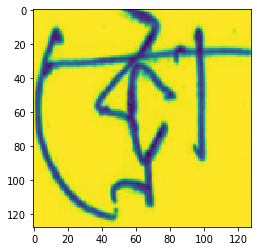

In [107]:
plt.imshow(cropped_imgs['Train_0'].reshape(128,128))

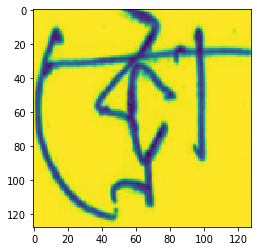

In [108]:
plt.imshow(cropped_imgs['Train_0'].reshape(128,128))